<a href="https://colab.research.google.com/github/Shadoww002/PyTorch-Learning/blob/main/Chapter%203%20%E2%80%93%20Computer%20Vision/ComputerVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## IMPORT LIBRARIES
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [2]:
## Getting Started With FashinMINST Datasets
train_data = datasets.FashionMNIST(
    root="Data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="Data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.91MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 22.4MB/s]


In [3]:
len(train_data) , len(test_data)

(60000, 10000)

In [4]:
train_data.data[0].shape

torch.Size([28, 28])

In [5]:
## Lets see The data

train_data[0] , train_data.test_labels[0]

/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


((tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
            0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
            0.2863, 0.0000, 0

In [6]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [8]:
image , lable = train_data[0]
image.size()

torch.Size([1, 28, 28])

In [9]:
class_name = train_data.classes
class_name

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

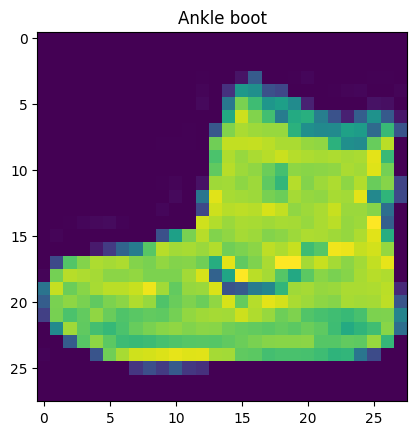

In [10]:
## Visualise The Data
plt.title(class_name[lable])
plt.imshow(image.squeeze())

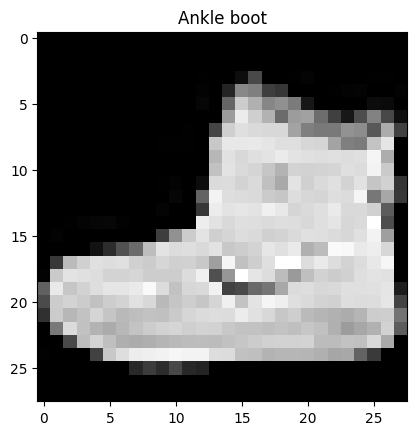

In [11]:
plt.title(class_name[lable])
plt.imshow(image.squeeze() ,
           cmap = "gray")

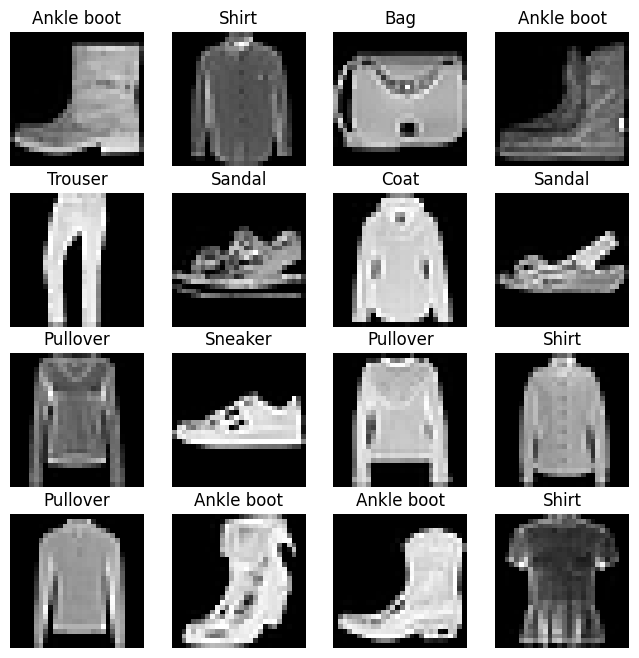

In [12]:
## Ploting The Random Images
torch.manual_seed(42)
plt.figure(figsize=(8,8))
rows , cols = 4 , 4

for i in range(1 , rows*cols+1):
  idx = torch.randint(0,len(train_data),size=[1])
  image , label = train_data[idx.squeeze()]
  class_name = train_data.classes[label]
  plt.subplot(rows , cols , i)
  plt.title(class_name)
  plt.imshow(image.squeeze(), cmap="gray")
  plt.axis(False)


In [13]:
torch.utils

<module 'torch.utils' from '/usr/local/lib/python3.11/dist-packages/torch/utils/__init__.py'>

In [14]:
##Preparing DataLoader
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                             batch_size = 32,
                             shuffle = True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size = 32,
                             shuffle = False)

In [15]:
len(train_dataloader) , len(test_dataloader)

(1875, 313)

In [16]:
60000/32 , 10000/32

(1875.0, 312.5)

In [17]:
## Interact with the Data Loader
train_features_batch , train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape , train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [18]:
class_name = train_data.classes

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

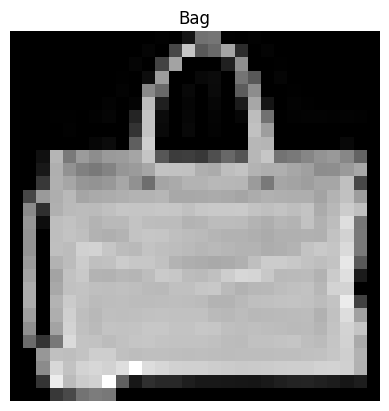

In [19]:
## Show a Sample
random_idx = torch.randint(0 , len(train_features_batch) , size=[1]).item()
img , label = train_features_batch[random_idx] , train_labels_batch[random_idx]
plt.title(class_name[label])
plt.imshow(img.squeeze(),cmap="gray")
plt.axis(False)

In [20]:
## Understnding the Flatten Layer Concept
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)

x.shape , output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [21]:
## Creating a BaselIne Model
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self,input_shape ,hidden_units, output_shape):
    super().__init__()
    self.LayerStack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features = output_shape)
    )

  def forward(self , x):
    return self.LayerStack(x)

In [22]:
28*28

784

In [23]:
torch.manual_seed(42)
model_0 = FashionMNISTModelV0(
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(class_name)
).to("cpu")

model_0

FashionMNISTModelV0(
  (LayerStack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [24]:
##Import HELPER Functions

import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [25]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [26]:
## Creating a Function To Time Experiments
from timeit import default_timer as timer

def print_train_time (
    start : float ,
    end : float,
    device : torch.device = None):

  total_time = end - start
  print(f"Train Time : {total_time:.3f} Sec on {device}")

  return total_time

In [27]:
len(train_dataloader.dataset)

60000

In [28]:
## Building a Train and Test loop

# import tqdm
from tqdm.auto import tqdm

#setting seed and start time
torch.manual_seed(42)
train_start_time_cpu = timer()

# Set epochs
epochs = 3

##creating a loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n------")
  ##Train Loop
  train_loss = 0
  for batch , (X,y) in enumerate(train_dataloader):
    model_0.train()

    y_pred = model_0(X)

    loss = loss_fn(y_pred , y)
    train_loss += loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch % 400 == 0 :
      print(f"Looked At : {batch*len(X)}/{len(train_dataloader.dataset)} samples")

  train_loss = train_loss/len(train_dataloader)

  ##Testing LOOP

  test_loss , test_acc = 0 ,0
  model_0.eval()
  with torch.inference_mode():
    for X , y in test_dataloader:

      test_pred = model_0(X)

      test_loss = test_loss + loss_fn(test_pred , y)

      test_acc += accuracy_fn(y_true=y , y_pred= test_pred.argmax(dim=1))

    test_loss /= len(test_dataloader)

    test_acc /= len(test_dataloader)

  print(f"\nTrain Loss : {train_loss:.5f} | test Loss : {test_loss:.5f} | Test Acc : {test_acc:.2f}%\n")

train_end_time_cpu = timer()
total_train_time_cpu = print_train_time(start=train_start_time_cpu,
                                        end=train_end_time_cpu,
                                        device = str(next(model_0.parameters()).device))






  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0
------
Looked At : 0/60000 samples
Looked At : 12800/60000 samples
Looked At : 25600/60000 samples
Looked At : 38400/60000 samples
Looked At : 51200/60000 samples

Train Loss : 0.59039 | test Loss : 0.50954 | Test Acc : 82.04%

Epoch : 1
------
Looked At : 0/60000 samples
Looked At : 12800/60000 samples
Looked At : 25600/60000 samples
Looked At : 38400/60000 samples
Looked At : 51200/60000 samples

Train Loss : 0.47633 | test Loss : 0.47989 | Test Acc : 83.20%

Epoch : 2
------
Looked At : 0/60000 samples
Looked At : 12800/60000 samples
Looked At : 25600/60000 samples
Looked At : 38400/60000 samples
Looked At : 51200/60000 samples

Train Loss : 0.45503 | test Loss : 0.47664 | Test Acc : 83.43%

Train Time : 30.563 Sec on cpu


In [29]:
## Making Predictions From BaseLine Model i.e Model_0

In [30]:
torch.manual_seed(42)

def eval_model(model : torch.nn.Module,
              data_loader : torch.utils.data.DataLoader,
              loss_fn : torch.nn.Module,
              accuracy_fn):

  loss , acc = 0 , 0
  model.eval()
  with torch.inference_mode():
    for X , y in data_loader:

      y_pred = model(X)

      loss += loss_fn(y_pred,y)
      acc += accuracy_fn(y_pred=y_pred.argmax(dim=1) ,
                         y_true = y )

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"Model_Name" : model.__class__.__name__,
          "Model_Loss" : loss.item(),
          "Model_acc" : acc}

In [31]:
model_0_results = eval_model(model=model_0,
                            data_loader=test_dataloader,
                            loss_fn = loss_fn,
                            accuracy_fn=accuracy_fn)

model_0_results

{'Model_Name': 'FashionMNISTModelV0',
 'Model_Loss': 0.47663894295692444,
 'Model_acc': 83.42651757188499}

In [32]:
## Lets Set Device Agnoistic Code and Make Use of GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [33]:
## Making The Model With NON-Linearlity
torch.manual_seed(42)

class FashionMNISTModelV1(nn.Module):
  def __init__(self,input_shape ,hidden_units , output_shape):
    super().__init__()

    self.Non_linearStack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.ReLU()
    )

  def forward(self , x ):
    return self.Non_linearStack(x)

In [34]:
model_1 = FashionMNISTModelV1(
    input_shape=28*28,
    hidden_units=16,
    output_shape=len(class_name)
).to(device)

model_1 , next(model_1.parameters()).device

(FashionMNISTModelV1(
   (Non_linearStack): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=784, out_features=16, bias=True)
     (2): ReLU()
     (3): Linear(in_features=16, out_features=16, bias=True)
     (4): ReLU()
     (5): Linear(in_features=16, out_features=10, bias=True)
     (6): ReLU()
   )
 ),
 device(type='cuda', index=0))

In [35]:
## Setting Loss And Optmizer Function
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.1)

In [36]:
## Lets Functionise the Train And Test LOOP

In [37]:
## Creating Train Loop Function
def Train_Step(model : torch.nn.Module,
               train_dataloader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               accuracy_fn,
               device : torch.device = device):

  train_loss = 0
  train_acc = 0
  model.train()
  model.to(device)

  for batch , (X , y) in enumerate(train_dataloader):

    X, y = X.to(device) , y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred , y)
    train_loss += loss

    acc = accuracy_fn(y_pred=y_pred.argmax(dim=1),
                        y_true = y)
    train_acc += acc


    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  print(f"Train_loss : {loss:.5f} | Train_Acc : {acc:.2f}%")


In [38]:
## Creating Function for testing LOOP
def Test_Step(model : torch.nn.Module,
               test_dataloader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               accuracy_fn,
               device : torch.device = device):

  loss = 0
  acc = 0
  model.eval()
  model.to(device)

  with torch.inference_mode():
    for X , y in test_dataloader :

      X,y = X.to(device) , y.to(device)

      test_pred = model(X)

      test_loss = loss_fn(test_pred , y)
      loss += test_loss

      test_acc = accuracy_fn(y_pred=test_pred.argmax(dim=1),
                             y_true = y)
      acc += test_acc

  loss = loss/len(test_dataloader)
  acc = acc/len(test_dataloader)

  print(f"Test_loss : {loss:.5f} | Test_Acc : {acc:.2f}%\n")


In [39]:
## Train and Test the Model

In [40]:
# import tqdm
from tqdm.auto import tqdm

#setting seed and start time
torch.manual_seed(42)
train_start_time_gpu = timer()
# Set epochs
epochs = 3

##creating a loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n------")
  ##Train Loop
  Train_Step(model = model_1 ,
             train_dataloader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device
             )


  ##Testing LOOP
  Test_Step(model=model_1,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device = device
             )

train_end_time_gpu = timer()
total_train_time_gpu = print_train_time(start=train_start_time_gpu,
                                        end=train_end_time_gpu,
                                        device = device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0
------
Train_loss : 0.44165 | Train_Acc : 93.75%
Test_loss : 0.71857 | Test_Acc : 76.71%

Epoch : 1
------
Train_loss : 0.90666 | Train_Acc : 78.12%
Test_loss : 0.67159 | Test_Acc : 79.49%

Epoch : 2
------
Train_loss : 0.51481 | Train_Acc : 87.50%
Test_loss : 0.63890 | Test_Acc : 82.00%

Train Time : 34.113 Sec on cuda


In [41]:
model_0_results

{'Model_Name': 'FashionMNISTModelV0',
 'Model_Loss': 0.47663894295692444,
 'Model_acc': 83.42651757188499}

In [42]:
torch.manual_seed(42)

def eval_model(model : torch.nn.Module,
              data_loader : torch.utils.data.DataLoader,
              loss_fn : torch.nn.Module,
              accuracy_fn,
               device : torch.device = device):

  loss , acc = 0 , 0
  model.eval()
  model.to(device)
  with torch.inference_mode():
    for X , y in data_loader:
      X , y = X.to(device) , y.to(device)

      y_pred = model(X)

      loss += loss_fn(y_pred,y)
      acc += accuracy_fn(y_pred=y_pred.argmax(dim=1) ,
                         y_true = y )

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"Model_Name" : model.__class__.__name__,
          "Model_Loss" : loss.item(),
          "Model_acc" : acc}

In [43]:
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             accuracy_fn=accuracy_fn,
                             loss_fn=loss_fn,
                             device=device)

In [44]:
model_1_results

{'Model_Name': 'FashionMNISTModelV1',
 'Model_Loss': 0.6388971209526062,
 'Model_acc': 81.9988019169329}

**Learning And Building CNN Model**

In [45]:
## Creating a CNN
class FashionMNiSTModelV2(nn.Module):
  def __init__(self , input_shape , hidden_units , output_shape):
    super().__init__()

    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=1)
    )

    self.block_2 = nn.Sequential(
        nn.Conv2d(hidden_units,hidden_units,3,padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units , hidden_units , 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )
  def forward(self , x):
    x = self.block_1(x)
    # print(x.shape)
    x = self.block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)

    return x

In [46]:
torch.manual_seed(42)
model_2 = FashionMNiSTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_name)).to(device)

model_2

FashionMNiSTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=10, bias=True)
  )
)

In [47]:
### Understanding The Conv2D and MaxPool2d Layers

In [48]:
torch.manual_seed(42)

# Create sample batch of random numbers with same size as image batch
images = torch.randn(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0] # get a single image for testing
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]")
print(f"Single image pixel values:\n{test_image}")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Single image pixel values:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,

In [49]:
torch.manual_seed(42)

# Create a convolutional layer with same dimensions as TinyVGG
# (try changing any of the parameters and see what happens)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0) # also try using "valid" or "same" here

# Pass the data through the convolutional layer
conv_layer(test_image) # Note: If running PyTorch <1.11.0, this will error because of shape issues (nn.Conv.2d() expects a 4d tensor as input)

tensor([[[ 1.5396,  0.0516,  0.6454,  ..., -0.3673,  0.8711,  0.4256],
         [ 0.3662,  1.0114, -0.5997,  ...,  0.8983,  0.2809, -0.2741],
         [ 1.2664, -1.4054,  0.3727,  ..., -0.3409,  1.2191, -0.0463],
         ...,
         [-0.1541,  0.5132, -0.3624,  ..., -0.2360, -0.4609, -0.0035],
         [ 0.2981, -0.2432,  1.5012,  ..., -0.6289, -0.7283, -0.5767],
         [-0.0386, -0.0781, -0.0388,  ...,  0.2842,  0.4228, -0.1802]],

        [[-0.2840, -0.0319, -0.4455,  ..., -0.7956,  1.5599, -1.2449],
         [ 0.2753, -0.1262, -0.6541,  ..., -0.2211,  0.1999, -0.8856],
         [-0.5404, -1.5489,  0.0249,  ..., -0.5932, -1.0913, -0.3849],
         ...,
         [ 0.3870, -0.4064, -0.8236,  ...,  0.1734, -0.4330, -0.4951],
         [-0.1984, -0.6386,  1.0263,  ..., -0.9401, -0.0585, -0.7833],
         [-0.6306, -0.2052, -0.3694,  ..., -1.3248,  0.2456, -0.7134]],

        [[ 0.4414,  0.5100,  0.4846,  ..., -0.8484,  0.2638,  1.1258],
         [ 0.8117,  0.3191, -0.0157,  ...,  1

In [50]:
# Add extra dimension to test image
test_image.unsqueeze(dim=0).shape

torch.Size([1, 3, 64, 64])

In [51]:
# Pass test image with extra dimension through conv_layer
conv_layer(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 10, 62, 62])

In [52]:
# Print out original image shape without and with unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(dim=0).shape}")

# Create a sample nn.MaxPoo2d() layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 31, 31])


In [53]:
torch.manual_seed(42)
# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"Random tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2) # see what happens when you change the kernel_size value

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n{max_pool_tensor} <- this is the maximum value from random_tensor")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
tensor([[[[0.3367]]]]) <- this is the maximum value from random_tensor
Max pool tensor shape: torch.Size([1, 1, 1, 1])


In [54]:
## step up tha Optimizer and Loss Function
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr = 0.1)

In [55]:
## Training and Testing LOOP
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#measure Time
from timeit import default_timer as timer
train_start_time_model_2 = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n ---")

  Train_Step(model= model_2,
             train_dataloader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device = device)

  Test_Step(model=model_2,
            test_dataloader=test_dataloader,
            accuracy_fn=accuracy_fn,
            loss_fn=loss_fn,
            device = device)


train_end_time_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_start_time_model_2,
                                            end=train_end_time_model_2,
                                            device = device
                                            )


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0
 ---
Train_loss : 0.36912 | Train_Acc : 87.50%
Test_loss : 0.38644 | Test_Acc : 86.53%

Epoch : 1
 ---
Train_loss : 0.46353 | Train_Acc : 81.25%
Test_loss : 0.32959 | Test_Acc : 88.17%

Epoch : 2
 ---
Train_loss : 0.29017 | Train_Acc : 90.62%
Test_loss : 0.32018 | Test_Acc : 88.46%

Train Time : 40.451 Sec on cuda


In [56]:
## model_2 results
model_2_results = eval_model(
    model=model_2,
    accuracy_fn=accuracy_fn,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    device = device
)
model_2_results

{'Model_Name': 'FashionMNiSTModelV2',
 'Model_Loss': 0.3201799690723419,
 'Model_acc': 88.45846645367412}

In [57]:
## Lest Compare
import pandas as pd

compare_results = pd.DataFrame([model_0_results,model_1_results,model_2_results])
compare_results

,Model_Name,Model_Loss,Model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.638897,81.998802
2,FashionMNiSTModelV2,0.320180,88.458466


In [58]:
compare_results["train_time"] = [total_train_time_cpu ,total_train_time_gpu,total_train_time_model_2]
compare_results

,Model_Name,Model_Loss,Model_acc,train_time
0,FashionMNISTModelV0,0.476639,83.426518,30.562564
1,FashionMNISTModelV1,0.638897,81.998802,34.112938
2,FashionMNiSTModelV2,0.320180,88.458466,40.450503


In [59]:
##Make and Evaluate Random Predictions with Best Model

def make_predictions(model : nn.Module,
                     data : list ,
                     device : torch.device = device):
  pred_probs =[]
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data :

      sample = torch.unsqueeze(sample , dim = 0).to(device)

      pred_logits = model(sample)

      pred_prob = torch.softmax(pred_logits.squeeze() , dim = 0 )

      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)


In [60]:
import random
# random.seed(42)

test_samples = []
test_labels = []

for sample , label in random.sample(list(test_data) , k = 9 ):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].shape



torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sneaker')

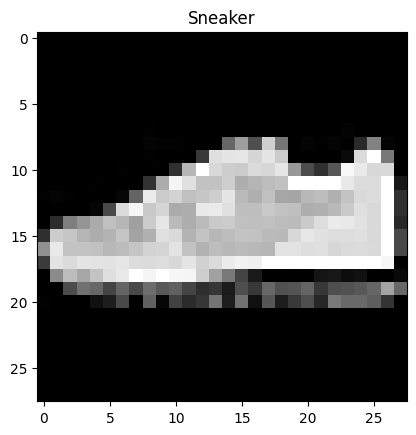

In [61]:
plt.imshow(test_samples[0].squeeze() , cmap="gray")
plt.title(class_name[test_labels[0]])

In [62]:
## Make predictions
pred_prods = make_predictions(model = model_2,
                              data = test_samples)

In [63]:
pred_prods[:4]

tensor([[2.7520e-06, 4.3210e-06, 1.1129e-05, 9.5268e-06, 1.6462e-05, 2.7193e-03,
         6.8220e-06, 9.9580e-01, 1.1234e-03, 3.0855e-04],
        [6.4173e-04, 5.2002e-05, 2.2946e-04, 2.9336e-04, 6.3740e-05, 9.6033e-01,
         1.2731e-04, 1.3932e-02, 2.4325e-02, 8.2969e-06],
        [8.8721e-04, 1.1482e-04, 1.2530e-03, 3.4691e-05, 5.9451e-01, 1.0079e-05,
         4.0265e-01, 2.3091e-06, 5.3573e-04, 2.0888e-06],
        [1.2734e-04, 1.0184e-05, 2.9517e-05, 7.4369e-05, 1.7503e-05, 6.6065e-03,
         1.5794e-04, 9.6723e-01, 1.4236e-03, 2.4324e-02]])

In [64]:
## Probs to labels
pred_classes = pred_prods.argmax(dim=1)
pred_classes

tensor([7, 5, 4, 7, 5, 0, 3, 8, 3])

In [65]:
test_labels

[7, 5, 4, 7, 5, 6, 3, 8, 3]

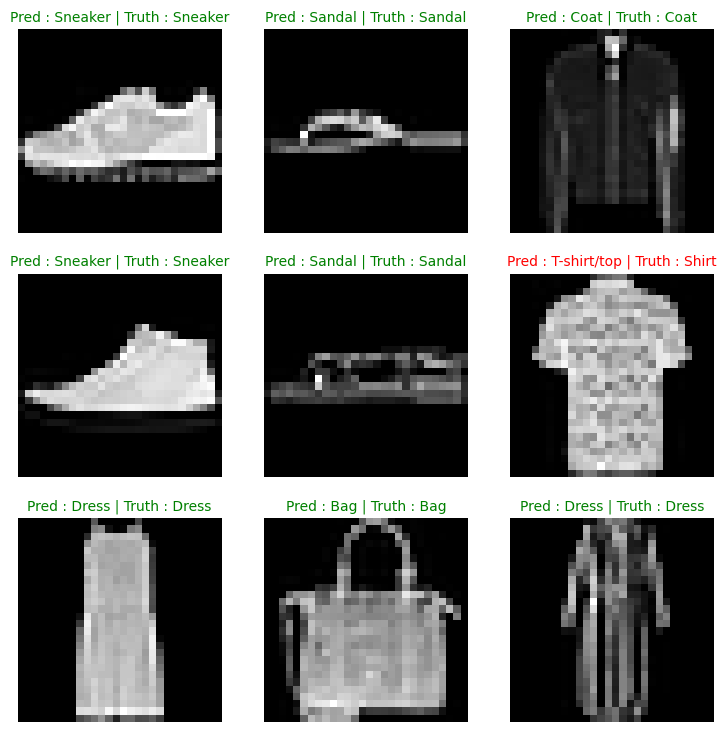

In [66]:
## Plot predictions
plt.figure(figsize=(9,9))
row = 3
col = 3

for i , sample in enumerate(test_samples):
  plt.subplot(row,col,i+1)

  plt.imshow(sample.squeeze(),cmap= "gray")

  pred_label = class_name[pred_classes[i]]
  truth_label = class_name[test_labels[i]]

  title_text = f"Pred : {pred_label} | Truth : {truth_label}"

  if pred_label == truth_label:
    plt.title(title_text , c = "g" ,fontsize = 10 )
  else: plt.title(title_text , c="r" , fontsize = 10)

  plt.axis(False)



In [67]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [68]:
y_pred_tensor.size()

torch.Size([10000])

In [69]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher


0.23.4


In [70]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [71]:
len(class_name)

10

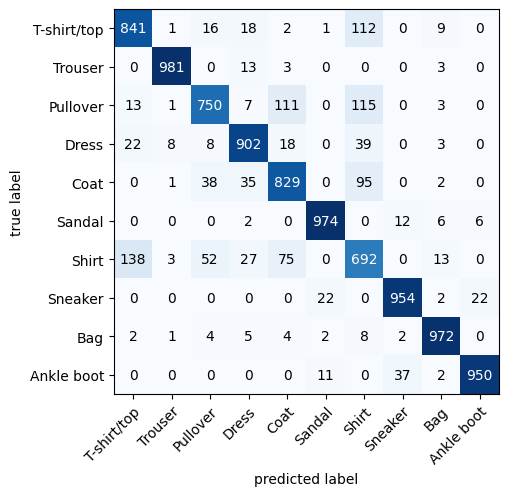

In [72]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_name),task='multiclass')
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = test_data.targets)

fig , ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_name,
    figsize=(8,5)
)